In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import cv2
from functools import partial
from collections import OrderedDict
import matplotlib
matplotlib.use('agg')
import sys
sys.path.insert(0, '../')
from model import get_vgg16, get_vgg16_deconv
from utils import decode_predictions

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    return img

In [3]:
def store(model):
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
            model.feature_maps[key] = output[0]
            model.pool_locs[key] = output[1]
        else:
            model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):
        layer.register_forward_hook(partial(hook, key=idx))

In [4]:
def vis_layer(layer, vgg, vgg_deconv):
    num_feat = vgg.feature_maps[layer].shape[1]
    
    new_feat_map = vgg.feature_maps[layer].clone()
    
    act_list = []
    for i in range(num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_list.append(activation.item())
        
    act_list = np.array(act_list)
    mark = np.argmax(act_list)
    
    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != vgg.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark+1:, :, :] = 0
            
    choose_map = torch.where(choose_map == max_activation, choose_map, torch.zeros(choose_map.shape))
    
    new_feat_map[0, mark, :, :] = choose_map
    
    deconv_output = vgg_deconv(new_feat_map, layer, mark, vgg16.pool_locs)
    
    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    
    return new_img, int(max_activation)

In [5]:
class Vgg16Conv(nn.Module):
    """
    vgg16 convolution network architecture
    """

    def __init__(self, num_cls=1000):
        """
        Input
            number of class, default is 1k.
        """
        super(Vgg16Conv, self).__init__()
    
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            
            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_cls),
            nn.Softmax(dim=1)
        )

        # index of conv
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        # feature maps
        self.feature_maps = OrderedDict()
        # switch
        self.pool_locs = OrderedDict()
        # initial weight
        self.init_weights()

    def init_weights(self):
        """
        initial weights from preptrained model by vgg16
        """
        vgg16_pretrained = models.vgg16(pretrained=True)
        # fine-tune Conv2d
        for idx, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[idx].weight.data = layer.weight.data
                self.features[idx].bias.data = layer.bias.data
        # fine-tune Linear
        for idx, layer in enumerate(vgg16_pretrained.classifier):
            if isinstance(layer, nn.Linear):
                self.classifier[idx].weight.data = layer.weight.data
                self.classifier[idx].bias.data = layer.bias.data
    
    def check(self):
        model = models.vgg16(pretrained=True)
        return model

    def forward(self, x):
        for idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
                # self.pool_locs[idx] = location
            else:
                x = layer(x)
        
        # reshape to (1, 512 * 7 * 7)
        x = x.view(x.size()[0], -1)
        output = self.classifier(x)
        return output

In [6]:
class Vgg16Deconv(nn.Module):
    """
    vgg16 transpose convolution network architecture
    """
    def __init__(self):
        super(Vgg16Deconv, self).__init__()

        self.features = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),

            # deconv2
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding=1),
            
            # deconv3
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding=1),
            
            # deconv4
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding=1),
            
            # deconv5
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding=1)    
        )

        self.conv2deconv_indices = {
                0:30, 2:28, 5:25, 7:23,
                10:20, 12:18, 14:16, 17:13,
                19:11, 21:9, 24:6, 26:4, 28:2
                }

        self.unpool2pool_indices = {
                26:4, 21:9, 14:16, 7:23, 0:30
                }

        self.init_weight()

    def init_weight(self):
        vgg16_pretrained = models.vgg16(pretrained=True)
        for idx, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                #self.features[self.conv2deconv_indices[idx]].bias.data\
                # = layer.bias.data
        
    def forward(self, x, layer, activation_idx, pool_locs):
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        else:
            raise ValueError('layer is not a conv feature map')

        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                x = self.features[idx]\
                (x, pool_locs[self.unpool2pool_indices[idx]])
            else:
                x = self.features[idx](x)
        return x

In [7]:
vgg16 = Vgg16Conv()
vgg16_deconv = Vgg16Deconv()
vgg16.eval()
store(vgg16)
vgg16_deconv.eval()

a = 2

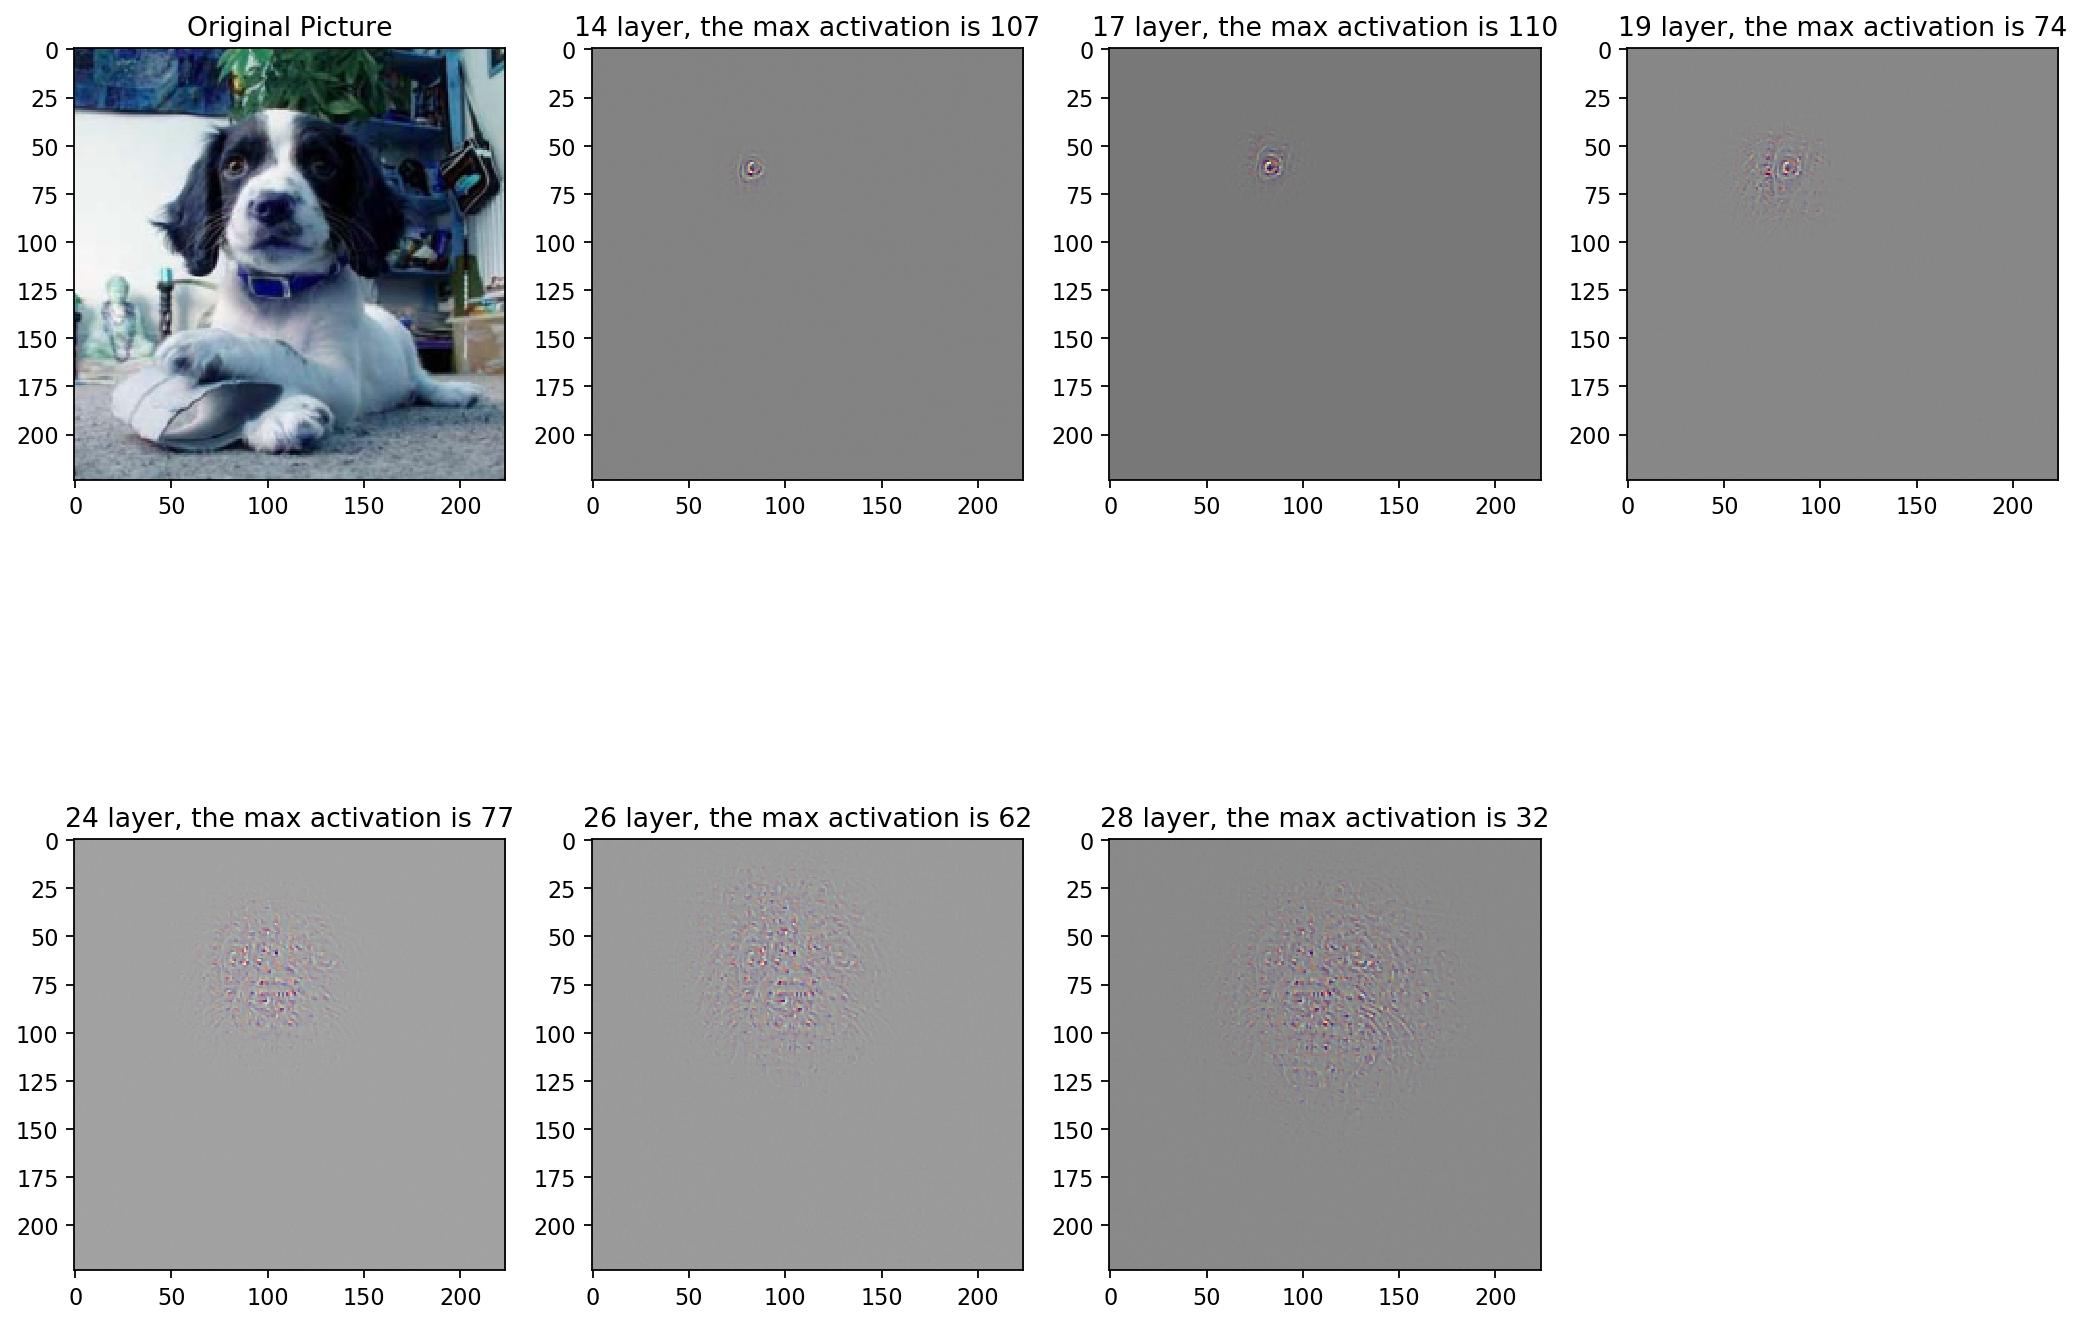

In [9]:
def show_visualization(path=None):
    if path is None:
        path = '/home/kushaj/Desktop/Data/imagenette-320/train/n02102040/n02102040_3006.JPEG'
    img = load_image(path)
    
    conv_out = vgg16(img)
    pool_locs = vgg16.pool_locs
#     print(f'Predicted: {decode_predictions(conv_out)[0]}')
    
    plt.figure(num=None, figsize=(16,12), dpi=160)
    plt.subplot(2, 4, 1)
    plt.title('Original Picture')
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    
    for idx, layer in enumerate([14, 17, 19, 24, 26, 28]):
        plt.subplot(2, 4, idx+2)
        img, activation = vis_layer(layer, vgg16, vgg16_deconv)
        plt.title(f'{layer} layer, the max activation is {activation}')
        plt.imshow(img)

    plt.savefig('result.jpg')
show_visualization()

In [2]:
import numpy as np
a = np.array([1, 4, 5, 7, 2, 1, 10, 9, 2, 3])

In [6]:
a.argsort()

array([0, 5, 4, 8, 9, 1, 2, 3, 7, 6])

In [8]:
a.argsort()[-1:-5:-1]

array([6, 7, 3, 2])

In [10]:
import torch
a = torch.rand(1, 512, 4, 5)

In [12]:
i = 0
a[:, 0:i, :, :]

tensor([], size=(1, 0, 4, 5))